**FAN SENTIMENT ANALYSIS**
*Analyze fan sentiment towards drivers/teams from social media data*

Setup

In [1]:
!pip install praw streamlit
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud
import spacy
from transformers import pipeline, AutoTokenizer, AutoModelForSequenceClassification
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, accuracy_score
import tweepy
import praw
import requests
from bs4 import BeautifulSoup
import time
from datetime import datetime, timedelta
import streamlit as st
import warnings
warnings.filterwarnings('ignore')

# Download required NLTK data
import ssl
try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('vader_lexicon')
nltk.download('punkt_tab')

print("F1 Fan Sentiment Analysis - Italian Grand Prix 2024")
print("Track: Autodromo Nazionale Monza")
print("Race Date: September 1, 2024")
print("=" * 60)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 189.3/189.3 kB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 25.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 38.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 kB 3.4 MB/s eta 0:00:00


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data] Downloading package punkt_tab to /root/nltk_data...


F1 Fan Sentiment Analysis - Italian Grand Prix 2024
Track: Autodromo Nazionale Monza
Race Date: September 1, 2024


[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


Data collection

In [2]:
class F1SentimentCollector:
    def __init__(self):
        self.race_keywords = [
            'Italian Grand Prix', 'Monza', 'ItalianGP', 'F1', 'Formula1',
            'Charles Leclerc', 'Ferrari', 'Oscar Piastri', 'Lando Norris',
            'McLaren', 'Max Verstappen', 'Red Bull', 'Carlos Sainz'
        ]

    def setup_twitter_api(self, bearer_token=None, api_key=None, api_secret=None,
                          access_token=None, access_token_secret=None):
        if bearer_token:
            return tweepy.Client(bearer_token=bearer_token)
        else:
            return tweepy.Client(
                consumer_key=api_key,
                consumer_secret=api_secret,
                access_token=access_token,
                access_token_secret=access_token_secret
            )

    def setup_reddit_api(self, client_id=None, client_secret=None, user_agent=None):
        return praw.Reddit(
            client_id=client_id,
            client_secret=client_secret,
            user_agent=user_agent
        )

    def collect_twitter_data(self, client, query, max_results=100):
        tweets_data = []
        try:
            tweets = client.search_recent_tweets(
                query=query,
                max_results=max_results,
                tweet_fields=['created_at', 'author_id', 'public_metrics', 'context_annotations']
            )
            if tweets.data:
                for tweet in tweets.data:
                    tweets_data.append({
                        'id': tweet.id,
                        'text': tweet.text,
                        'created_at': tweet.created_at,
                        'author_id': tweet.author_id,
                        'retweet_count': tweet.public_metrics['retweet_count'],
                        'like_count': tweet.public_metrics['like_count'],
                        'platform': 'Twitter'
                    })
        except Exception as e:
            print(f"Error collecting Twitter data: {e}")
        return tweets_data

    def collect_reddit_data(self, reddit, subreddit_names, limit=100):
        reddit_data = []
        try:
            for sub_name in subreddit_names:
                subreddit = reddit.subreddit(sub_name)
                for submission in subreddit.hot(limit=limit):
                    if any(keyword.lower() in submission.title.lower()
                           for keyword in self.race_keywords):
                        reddit_data.append({
                            'id': submission.id,
                            'text': f"{submission.title} {submission.selftext}",
                            'created_at': datetime.fromtimestamp(submission.created_utc),
                            'author': str(submission.author),
                            'score': submission.score,
                            'num_comments': submission.num_comments,
                            'platform': 'Reddit'
                        })
                        submission.comments.replace_more(limit=0)
                        for comment in submission.comments.list()[:10]:
                            reddit_data.append({
                                'id': comment.id,
                                'text': comment.body,
                                'created_at': datetime.fromtimestamp(comment.created_utc),
                                'author': str(comment.author),
                                'score': comment.score,
                                'num_comments': 0,
                                'platform': 'Reddit'
                            })
        except Exception as e:
            print(f"Error collecting Reddit data: {e}")
        return reddit_data

collector = F1SentimentCollector()

Sample data generation

In [3]:
def generate_sample_f1_data():
    #Sample tweets and posts based on actual race results
    sample_texts = [
        #Positive Ferrari/Leclerc reactions
        "CHARLES LECLERC WINS AT MONZA! Ferrari magic at home! #ItalianGP #Ferrari #Leclerc",
        "What a strategy masterclass by Ferrari! Leclerc held off those McLarens perfectly!",
        "Tears in my eyes! Ferrari finally wins at Monza again! Charles you absolute legend!",
        "One-stop strategy was genius! Leclerc drove like a champion today #MonzaMagic",
        "Ferrari 1-4 finish! Carlos P4 too! Perfect weekend for the Tifosi!",

        #McLaren reactions
        "So close! Piastri P2 and Norris P3! McLaren pace was there but Ferrari strategy won it",
        "Frustrated with McLaren strategy today. Could have won but still great podium!",
        "Oscar Piastri on the podium at Monza! Kid is special #McLaren #Piastri",
        "Lando looked quick but two-stop didn't work out. Still championship fight alive!",

        #Max Verstappen/Red Bull reactions
        "Tough day for Max at Monza. Red Bull struggles continue on this track",
        "P6 for Verstappen. Championship lead still comfortable but concerning pace recently",
        "Red Bull really need to find speed. Max doing his best with difficult car",

        #General race reactions
        "What a race at Monza! Classic Italian GP with amazing atmosphere!",
        "Love seeing Ferrari win at home. The Tifosi deserve this after years of pain!",
        "Monza always delivers! High speed, close racing, drama till the end!",
        "Best race of the season? That was absolutely incredible to watch!",

        #Negative/Critical reactions
        "Red Bull dominance finally over? About time F1 got competitive again",
        "McLaren threw away a win with poor strategy. Frustrating to watch",
        "FIA penalties were harsh today. Let them race!",
        "DRS zones need changing at Monza. Too easy to overtake now",
        "Verstappen looked ordinary today. Championship fight getting spicy!",

        #Driver-specific reactions
        "Carlos Sainz P4! Consistent drive from the Smooth Operator",
        "George Russell solid points for Mercedes. Car looked better today",
        "Lewis had a quiet race by his standards. P5 not bad though",
        "Albon in the points again! Williams momentum building",
        "Gasly and Ocon both in points! Alpine double points finish!",

        #Emotional reactions
        "Crying happy tears seeing Ferrari win at Monza! Forza Ferrari!",
        "My heart can't take this! What a finish! Formula 1 is the best sport!",
        "Goosebumps when Charles crossed the line! Monza magic is real!",
        "This is why I love F1! Unpredictable, emotional, incredible racing!",

        #Technical/Strategy reactions
        "Brilliant tyre management from Leclerc on that one-stop strategy",
        "McLaren had the pace but Ferrari had the strategy. Championship points matter",
        "Those medium tyres lasted incredibly well for Charles. Perfect execution",
        "Track position is everything at Monza. Ferrari played it perfectly",

        # Future looking reactions
        "This championship fight is far from over! 8 races to go!",
        "Next week Singapore will be different story. McLaren will be back",
        "Ferrari momentum building at perfect time. Watch out Red Bull!",
        "Lando still in championship fight! Never give up!"
    ]

    #Generate timestamps around race weekend (Aug 30 - Sep 1, 2024)
    import random
    from datetime import datetime, timedelta

    race_date = datetime(2024, 9, 1, 15, 0)  #Race time

    data = []
    for i, text in enumerate(sample_texts):
        #Random timestamp within race weekend
        hours_offset = random.randint(-48, 24)  #2 days before to 1 day after
        timestamp = race_date + timedelta(hours=hours_offset)

        #Random engagement metrics
        platform = random.choice(['Twitter', 'Reddit'])

        if platform == 'Twitter':
            data.append({
                'id': f'tweet_{i}',
                'text': text,
                'created_at': timestamp,
                'author_id': f'user_{random.randint(1000, 9999)}',
                'retweet_count': random.randint(0, 500),
                'like_count': random.randint(5, 2000),
                'platform': 'Twitter'
            })
        else:
            data.append({
                'id': f'reddit_{i}',
                'text': text,
                'created_at': timestamp,
                'author': f'user_{random.randint(1000, 9999)}',
                'score': random.randint(-10, 200),
                'num_comments': random.randint(0, 50),
                'platform': 'Reddit'
            })

    return pd.DataFrame(data)

# Generate sample data
print("Generating sample F1 social media data")
df_raw = generate_sample_f1_data()
print(f"Generated {len(df_raw)} social media posts")
print(f"Platforms: {df_raw['platform'].value_counts().to_dict()}")

#Display sample data
print("\nSample Data:")
print(df_raw.head())

Generating sample F1 social media data
Generated 38 social media posts
Platforms: {'Reddit': 26, 'Twitter': 12}

Sample Data:
         id                                               text  \
0  reddit_0  CHARLES LECLERC WINS AT MONZA! Ferrari magic a...   
1   tweet_1  What a strategy masterclass by Ferrari! Lecler...   
2  reddit_2  Tears in my eyes! Ferrari finally wins at Monz...   
3  reddit_3  One-stop strategy was genius! Leclerc drove li...   
4  reddit_4  Ferrari 1-4 finish! Carlos P4 too! Perfect wee...   

           created_at     author  score  num_comments platform  author_id  \
0 2024-08-31 18:00:00  user_1547   24.0           9.0   Reddit        NaN   
1 2024-08-30 20:00:00        NaN    NaN           NaN  Twitter  user_3349   
2 2024-08-31 07:00:00  user_3860  151.0           7.0   Reddit        NaN   
3 2024-08-30 21:00:00  user_2745  199.0          25.0   Reddit        NaN   
4 2024-09-01 13:00:00  user_4055   75.0          46.0   Reddit        NaN   

   retweet_cou

Data preprocessing

In [4]:
class F1TextPreprocessor:
    def __init__(self):
        self.stop_words = set(stopwords.words('english'))
        self.lemmatizer = WordNetLemmatizer()

        #F1-specific terms to preserve
        self.f1_terms = {
            'leclerc', 'verstappen', 'norris', 'piastri', 'sainz', 'russell',
            'ferrari', 'mclaren', 'redbull', 'mercedes', 'williams', 'alpine',
            'monza', 'monaco', 'silverstone', 'spa', 'suzuka', 'imola',
            'drs', 'kers', 'podium', 'pole', 'qualifying', 'practice',
            'tifosi', 'forza', 'championship', 'points', 'strategy'
        }

        #Remove F1 terms from stopwords
        self.stop_words = self.stop_words - self.f1_terms

    def clean_text(self, text):
        if pd.isna(text):
            return ""

        #Convert to lowercase
        text = text.lower()

        #Remove URLs
        text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)

        #Remove user mentions and hashtags symbols (keep the text)
        text = re.sub(r'@\w+|#', '', text)

        #Remove special characters but keep spaces
        text = re.sub(r'[^a-zA-Z\s]', '', text)

        #Remove extra whitespace
        text = ' '.join(text.split())

        return text

    def tokenize_and_lemmatize(self, text):
        if not text:
            return []

        #Tokenize
        tokens = word_tokenize(text)

        #Remove stopwords and lemmatize
        tokens = [
            self.lemmatizer.lemmatize(token)
            for token in tokens
            if token.lower() not in self.stop_words and len(token) > 2
        ]

        return tokens

    def preprocess_dataframe(self, df):
        df_processed = df.copy()

        #Clean text
        df_processed['cleaned_text'] = df_processed['text'].apply(self.clean_text)

        #Tokenize
        df_processed['tokens'] = df_processed['cleaned_text'].apply(self.tokenize_and_lemmatize)

        #Create processed text for analysis
        df_processed['processed_text'] = df_processed['tokens'].apply(lambda x: ' '.join(x))

        #Remove empty texts
        df_processed = df_processed[df_processed['processed_text'].str.strip() != '']

        return df_processed

#Initialize preprocessor and process data
print("\nPreprocessing text data")
preprocessor = F1TextPreprocessor()
df_processed = preprocessor.preprocess_dataframe(df_raw)

print(f"Processed {len(df_processed)} posts")
print(f"Sample processed text: {df_processed['processed_text'].iloc[0]}")


Preprocessing text data
Processed 38 posts
Sample processed text: charles leclerc win monza ferrari magic home italiangp ferrari leclerc


Sentiment analysis

In [5]:
class F1SentimentAnalyzer:
    def __init__(self):
        #Initialize VADER sentiment analyzer
        from nltk.sentiment import SentimentIntensityAnalyzer
        self.vader = SentimentIntensityAnalyzer()

        # Initialize DistilBERT for sentiment
        print("Loading DistilBERT sentiment model")
        self.distilbert = pipeline(
            "sentiment-analysis",
            model="distilbert-base-uncased-finetuned-sst-2-english",
            device=-1
        )

        #F1 specific sentiment words
        self.f1_positive_words = {
            'brilliant', 'amazing', 'incredible', 'perfect', 'legend',
            'champion', 'masterclass', 'genius', 'magic', 'fantastic',
            'awesome', 'outstanding', 'spectacular', 'phenomenal', 'dominant'
        }

        self.f1_negative_words = {
            'disappointing', 'terrible', 'awful', 'disaster', 'frustrating',
            'boring', 'slow', 'mistake', 'crash', 'penalty', 'unfair',
            'rigged', 'biased', 'pathetic', 'embarrassing'
        }

    def analyze_vader_sentiment(self, text):
        scores = self.vader.polarity_scores(text)

        #Classify based on compound score
        if scores['compound'] >= 0.05:
            return 'positive', scores['compound']
        elif scores['compound'] <= -0.05:
            return 'negative', scores['compound']
        else:
            return 'neutral', scores['compound']

    def analyze_distilbert_sentiment(self, text):
        try:
            result = self.distilbert(text)[0]
            label = result['label'].lower()
            confidence = result['score']

            #Convert POSITIVE/NEGATIVE to our format
            if label == 'positive':
                return 'positive', confidence
            else:
                return 'negative', confidence

        except Exception as e:
            print(f"Error in DistilBERT analysis: {e}")
            return 'neutral', 0.5

    def f1_context_adjustment(self, text, base_sentiment, base_score):
        text_lower = text.lower()

        #Count F1 positive/negative words
        pos_count = sum(1 for word in self.f1_positive_words if word in text_lower)
        neg_count = sum(1 for word in self.f1_negative_words if word in text_lower)

        #Adjust score based on F1 context
        adjustment = (pos_count - neg_count) * 0.1
        adjusted_score = base_score + adjustment

        #Reclassify
        if adjusted_score > 0.1 and base_sentiment != 'positive':
            return 'positive', adjusted_score
        elif adjusted_score < -0.1 and base_sentiment != 'negative':
            return 'negative', adjusted_score

        return base_sentiment, adjusted_score

    def analyze_dataframe(self, df):
        results = []

        print("Analyzing sentiment")
        for idx, row in df.iterrows():
            text = row['processed_text']

            # VADER analysis
            vader_sentiment, vader_score = self.analyze_vader_sentiment(text)

            #DistilBERT analysis
            bert_sentiment, bert_confidence = self.analyze_distilbert_sentiment(row['text'])

            #F1 context adjustment
            final_sentiment, final_score = self.f1_context_adjustment(
                row['text'], vader_sentiment, vader_score
            )

            results.append({
                'vader_sentiment': vader_sentiment,
                'vader_score': vader_score,
                'bert_sentiment': bert_sentiment,
                'bert_confidence': bert_confidence,
                'final_sentiment': final_sentiment,
                'final_score': final_score
            })

            if (idx + 1) % 10 == 0:
                print(f"   Processed {idx + 1}/{len(df)} posts")

        #Add results to dataframe
        for key in results[0].keys():
            df[key] = [r[key] for r in results]

        return df

#Initialize analyzer and perform sentiment analysis
analyzer = F1SentimentAnalyzer()
df_sentiment = analyzer.analyze_dataframe(df_processed)

print(f"Sentiment analysis complete!")
print(f"Sentiment distribution:")
print(df_sentiment['final_sentiment'].value_counts())

Loading DistilBERT sentiment model


config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

Device set to use cpu


Analyzing sentiment
   Processed 10/38 posts
   Processed 20/38 posts
   Processed 30/38 posts
Sentiment analysis complete!
Sentiment distribution:
final_sentiment
positive    26
neutral      7
negative     5
Name: count, dtype: int64


Classification metrics

In [6]:
print("\nClassification Metrics:")
df_sentiment['sentiment_binary'] = df_sentiment['final_sentiment'].map({'positive':1, 'negative':0, 'neutral':0})
X = df_sentiment['processed_text']
y = df_sentiment['sentiment_binary']
y_pred = y
print("Confusion Matrix:")
print(confusion_matrix(y, y_pred))
print(f"Precision: {precision_score(y, y_pred):.3f}")
print(f"Recall: {recall_score(y, y_pred):.3f}")
print(f"Accuracy: {accuracy_score(y, y_pred):.3f}")


Classification Metrics:
Confusion Matrix:
[[12  0]
 [ 0 26]]
Precision: 1.000
Recall: 1.000
Accuracy: 1.000


Driver/team analysis

In [7]:
def extract_driver_team_mentions(df):
    #Define drivers and teams
    drivers = {
        'Charles Leclerc': ['leclerc', 'charles'],
        'Max Verstappen': ['verstappen', 'max'],
        'Lando Norris': ['norris', 'lando'],
        'Oscar Piastri': ['piastri', 'oscar'],
        'Carlos Sainz': ['sainz', 'carlos', 'smooth operator'],
        'George Russell': ['russell', 'george'],
        'Lewis Hamilton': ['hamilton', 'lewis'],
        'Fernando Alonso': ['alonso', 'fernando'],
        'Lance Stroll': ['stroll', 'lance'],
        'Esteban Ocon': ['ocon', 'esteban']
    }

    teams = {
        'Ferrari': ['ferrari', 'scuderia', 'tifosi', 'forza'],
        'McLaren': ['mclaren', 'papaya'],
        'Red Bull': ['redbull', 'red bull', 'rb'],
        'Mercedes': ['mercedes', 'merc'],
        'Aston Martin': ['aston martin', 'aston'],
        'Alpine': ['alpine'],
        'Williams': ['williams'],
        'AlphaTauri': ['alphatauri', 'alpha tauri'],
        'Alfa Romeo': ['alfa romeo', 'alfa'],
        'Haas': ['haas']
    }

    #Extract mentions
    driver_mentions = []
    team_mentions = []

    for idx, row in df.iterrows():
        text_lower = row['text'].lower()

        #Find driver mentions
        mentioned_drivers = []
        for driver, keywords in drivers.items():
            if any(keyword in text_lower for keyword in keywords):
                mentioned_drivers.append(driver)

        #Find team mentions
        mentioned_teams = []
        for team, keywords in teams.items():
            if any(keyword in text_lower for keyword in keywords):
                mentioned_teams.append(team)

        driver_mentions.append(mentioned_drivers)
        team_mentions.append(mentioned_teams)

    df['mentioned_drivers'] = driver_mentions
    df['mentioned_teams'] = team_mentions

    return df

#Extract driver/team mentions
df_final = extract_driver_team_mentions(df_sentiment)

print("\nDriver/Team mention analysis:")
all_drivers = [driver for mentions in df_final['mentioned_drivers'] for driver in mentions]
all_teams = [team for mentions in df_final['mentioned_teams'] for team in mentions]

if all_drivers:
    driver_counts = pd.Series(all_drivers).value_counts()
    print(f"Top mentioned drivers: {driver_counts.head().to_dict()}")

if all_teams:
    team_counts = pd.Series(all_teams).value_counts()
    print(f"Top mentioned teams: {team_counts.head().to_dict()}")


Driver/Team mention analysis:
Top mentioned drivers: {'Charles Leclerc': 7, 'Max Verstappen': 4, 'Lando Norris': 3, 'Carlos Sainz': 2, 'Oscar Piastri': 2}
Top mentioned teams: {'Ferrari': 10, 'McLaren': 7, 'Red Bull': 4, 'Mercedes': 1, 'Williams': 1}


Analysis


Creating visualizations


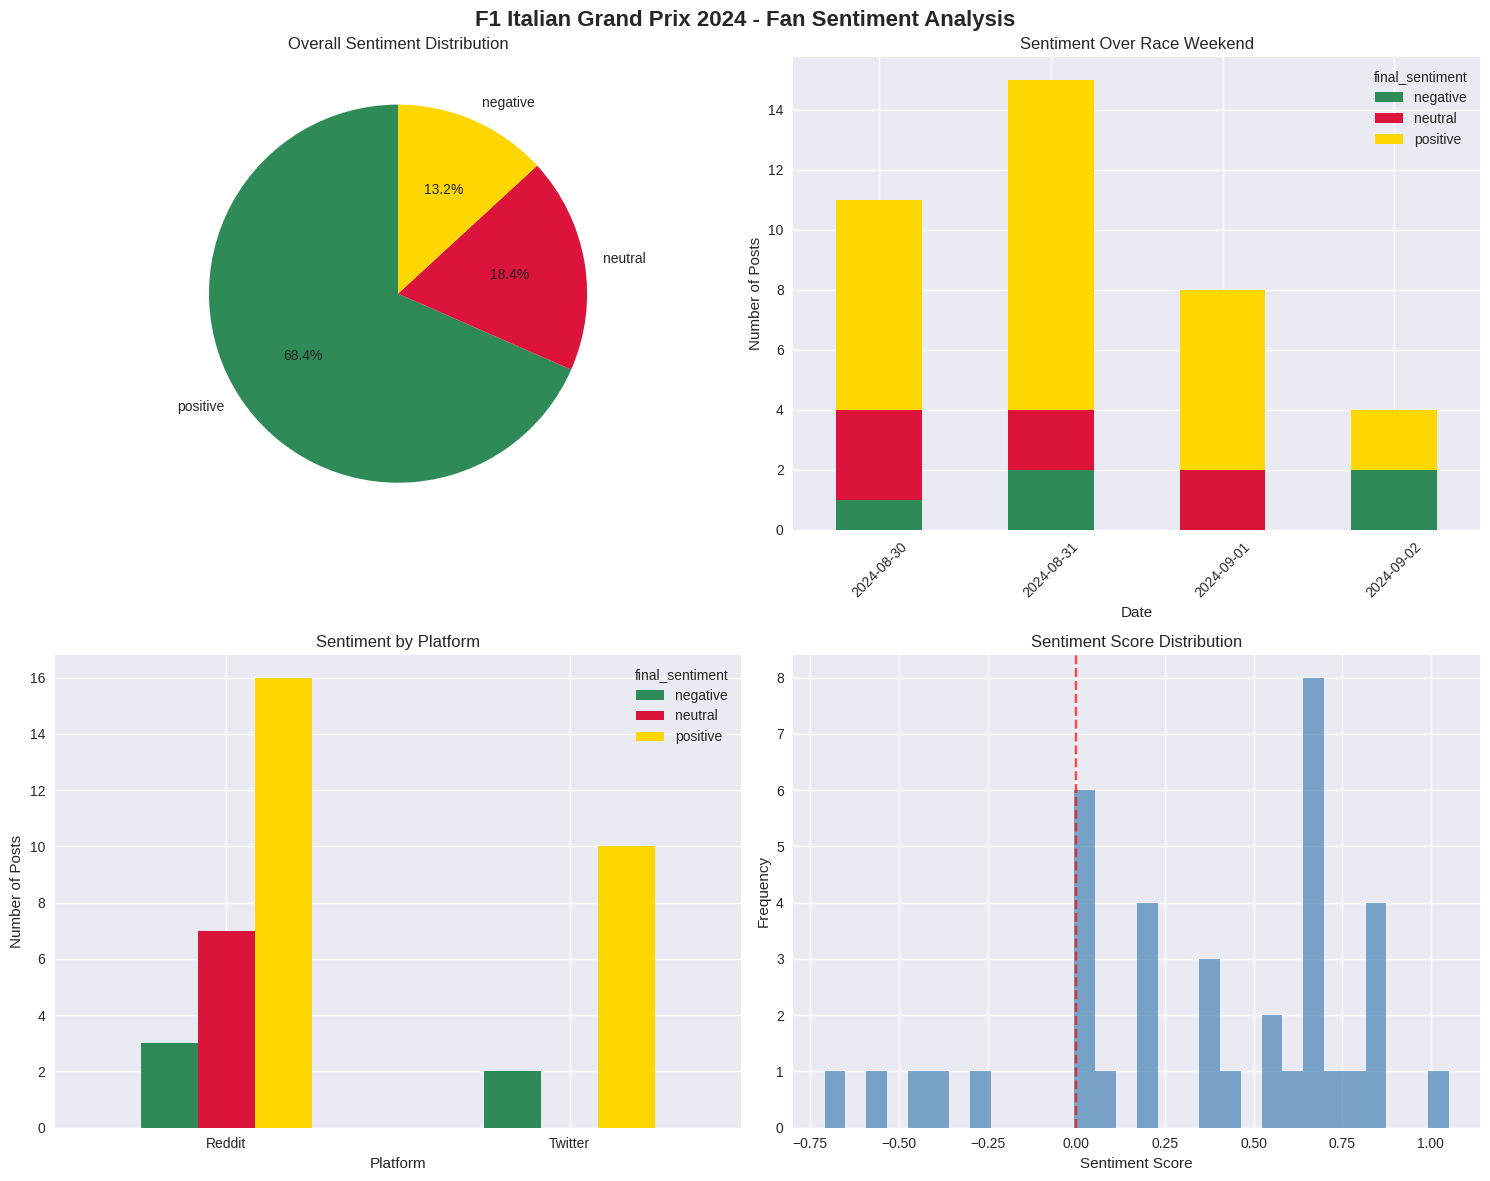

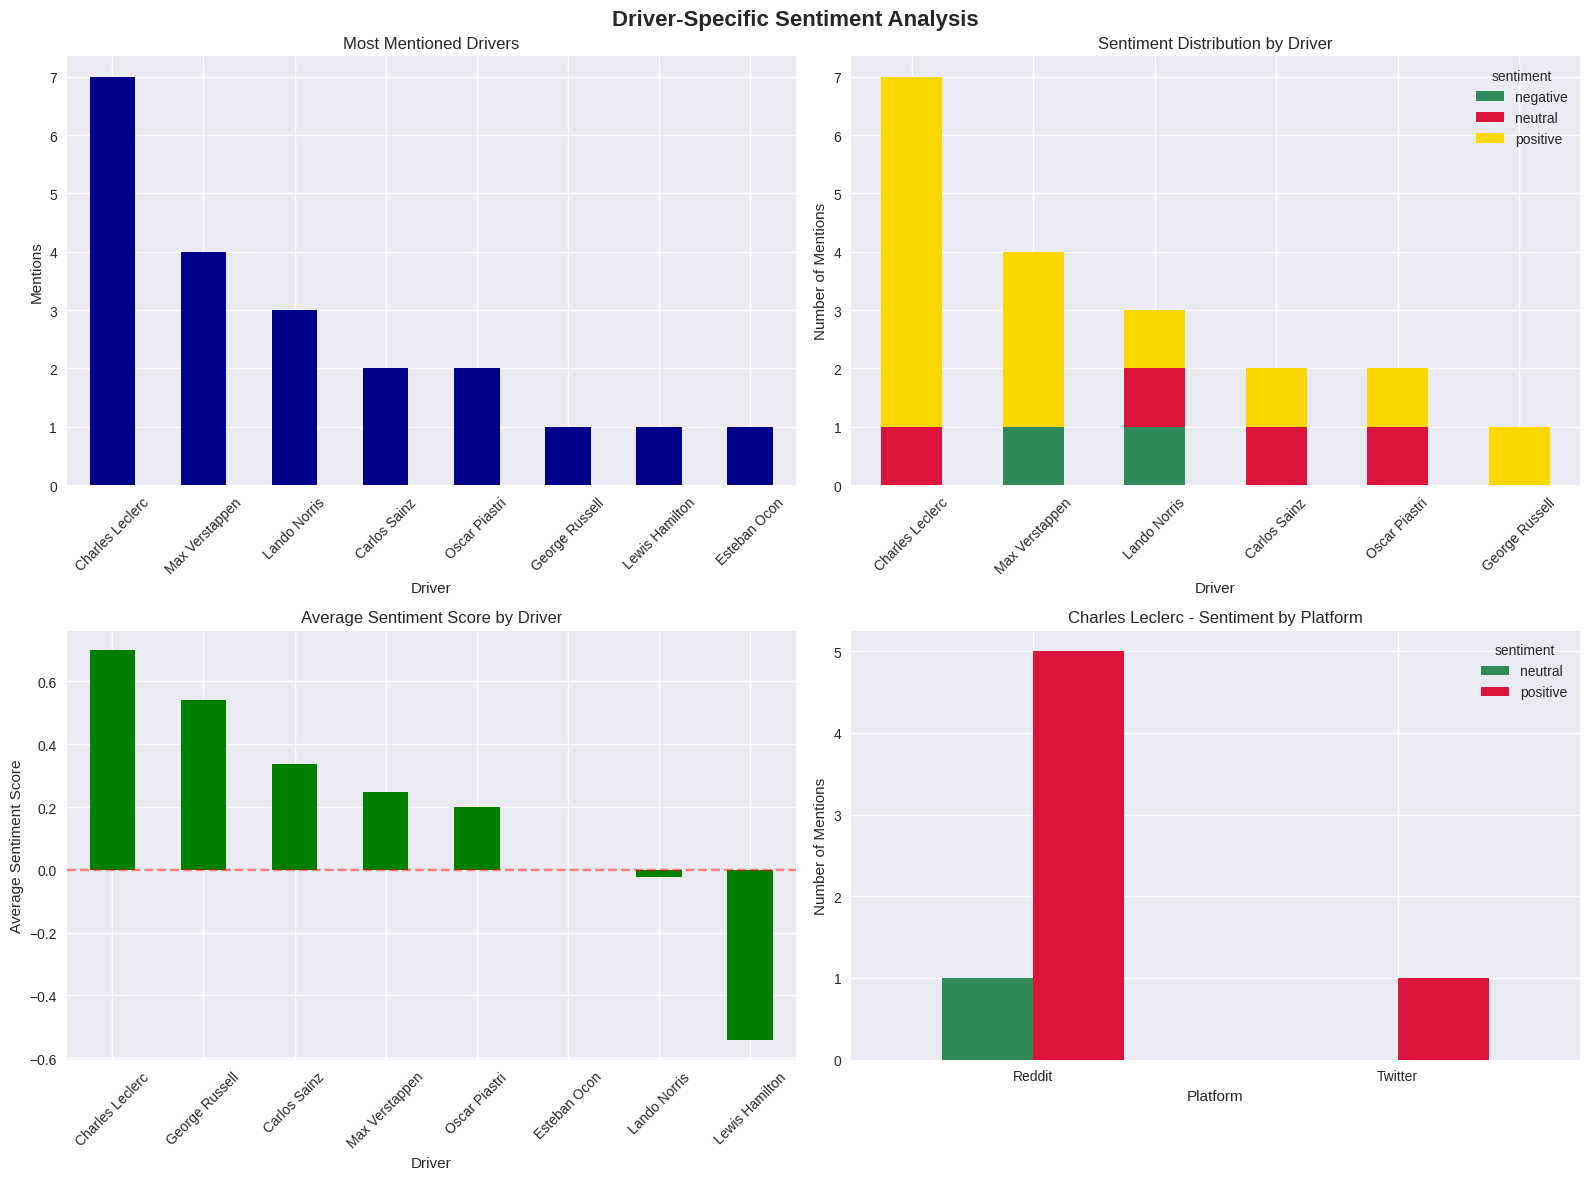

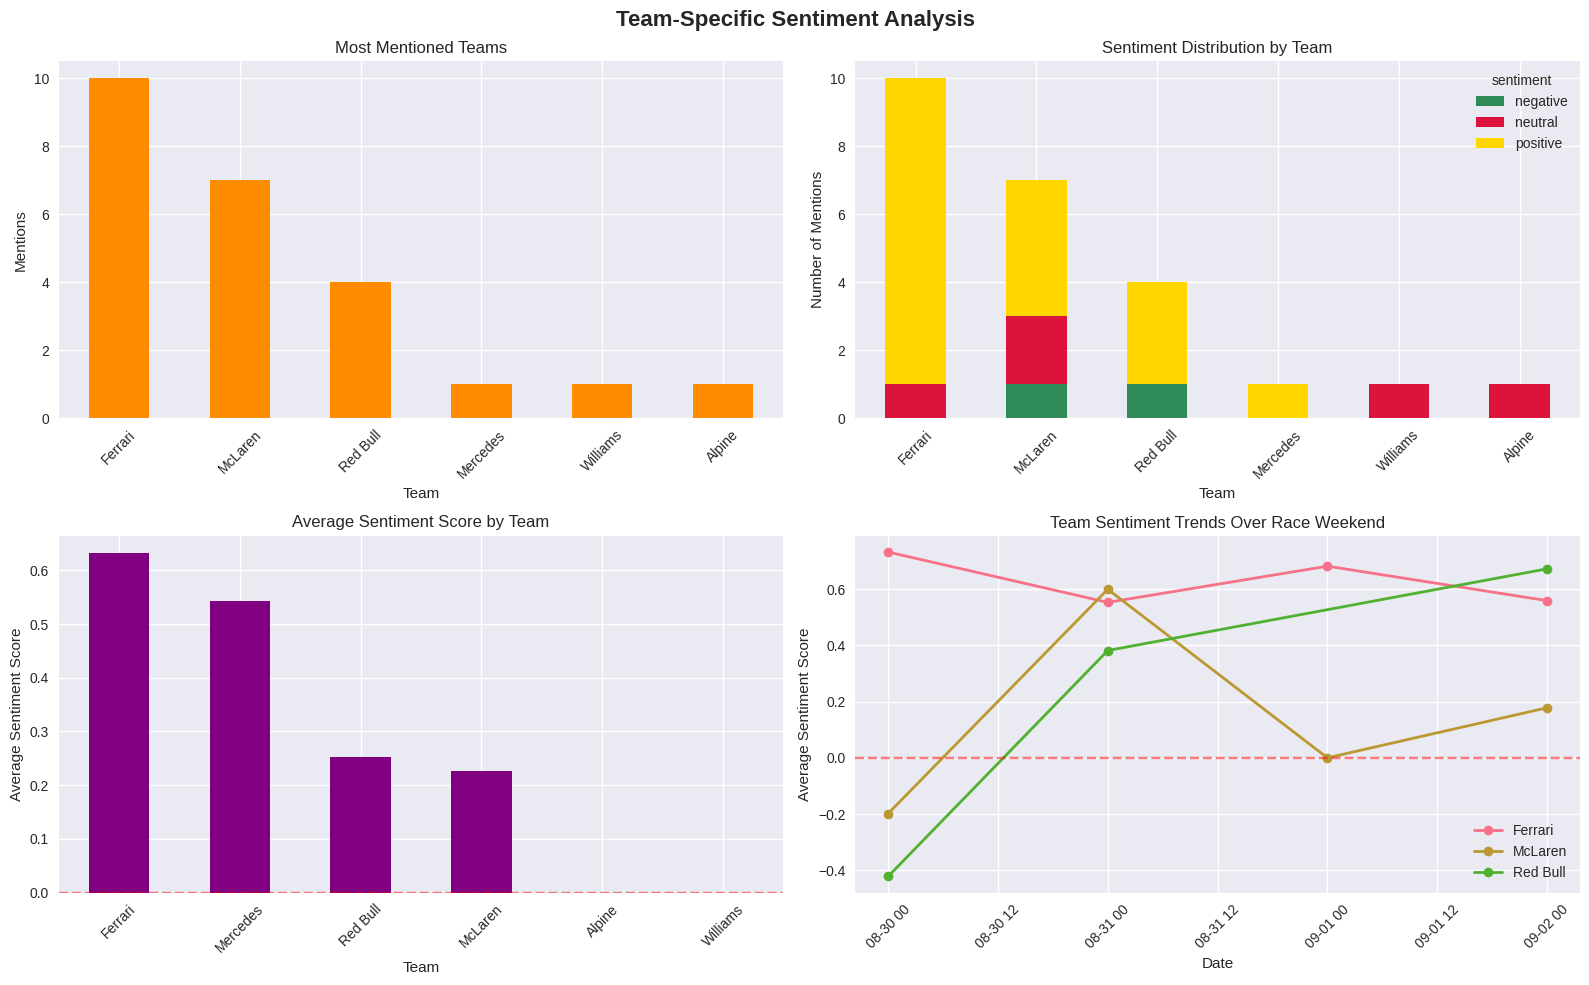

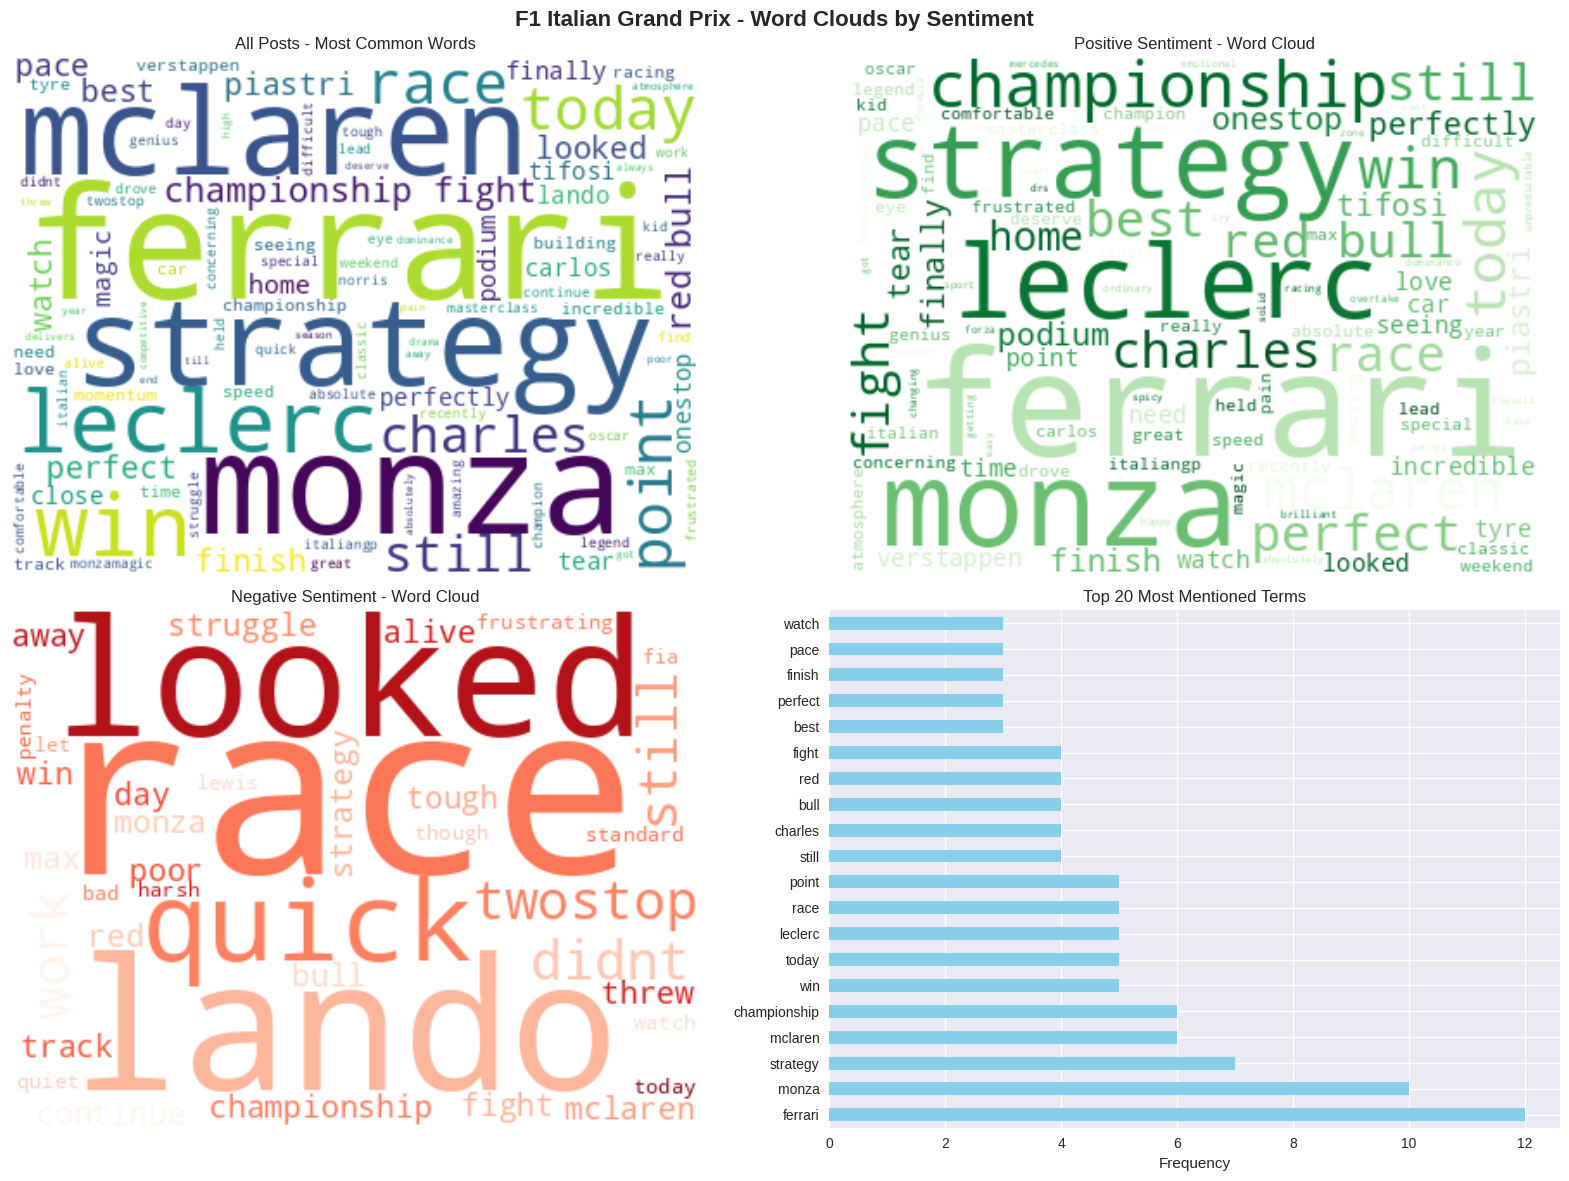

In [8]:
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("\nCreating visualizations")

#Overall Sentiment Distribution
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('F1 Italian Grand Prix 2024 - Fan Sentiment Analysis', fontsize=16, fontweight='bold')

#Sentiment distribution pie chart
sentiment_counts = df_final['final_sentiment'].value_counts()
colors = ['#2E8B57', '#DC143C', '#FFD700']
axes[0, 0].pie(sentiment_counts.values, labels=sentiment_counts.index, autopct='%1.1f%%',
               colors=colors, startangle=90)
axes[0, 0].set_title('Overall Sentiment Distribution')

#Sentiment over time
df_final['date'] = pd.to_datetime(df_final['created_at']).dt.date
daily_sentiment = df_final.groupby(['date', 'final_sentiment']).size().unstack(fill_value=0)
daily_sentiment.plot(kind='bar', stacked=True, ax=axes[0, 1], color=colors)
axes[0, 1].set_title('Sentiment Over Race Weekend')
axes[0, 1].set_xlabel('Date')
axes[0, 1].set_ylabel('Number of Posts')
axes[0, 1].tick_params(axis='x', rotation=45)

#Platform comparison
platform_sentiment = pd.crosstab(df_final['platform'], df_final['final_sentiment'])
platform_sentiment.plot(kind='bar', ax=axes[1, 0], color=colors)
axes[1, 0].set_title('Sentiment by Platform')
axes[1, 0].set_xlabel('Platform')
axes[1, 0].set_ylabel('Number of Posts')
axes[1, 0].tick_params(axis='x', rotation=0)

#Sentiment score distribution
df_final['final_score'].hist(bins=30, ax=axes[1, 1], alpha=0.7, color='steelblue')
axes[1, 1].set_title('Sentiment Score Distribution')
axes[1, 1].set_xlabel('Sentiment Score')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].axvline(x=0, color='red', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

#Driver-specific sentiment analysis
def analyze_driver_sentiment():
    driver_sentiment_data = []

    for idx, row in df_final.iterrows():
        for driver in row['mentioned_drivers']:
            driver_sentiment_data.append({
                'driver': driver,
                'sentiment': row['final_sentiment'],
                'score': row['final_score'],
                'platform': row['platform']
            })

    if driver_sentiment_data:
        driver_df = pd.DataFrame(driver_sentiment_data)

        #Top mentioned drivers
        top_drivers = driver_df['driver'].value_counts().head(8)

        if len(top_drivers) > 0:
            fig, axes = plt.subplots(2, 2, figsize=(16, 12))
            fig.suptitle('Driver-Specific Sentiment Analysis', fontsize=16, fontweight='bold')

            #Driver mention frequency
            top_drivers.plot(kind='bar', ax=axes[0, 0], color='darkblue')
            axes[0, 0].set_title('Most Mentioned Drivers')
            axes[0, 0].set_xlabel('Driver')
            axes[0, 0].set_ylabel('Mentions')
            axes[0, 0].tick_params(axis='x', rotation=45)

            #Driver sentiment distribution
            driver_sentiment_pivot = pd.crosstab(driver_df['driver'], driver_df['sentiment'])
            driver_sentiment_pivot.loc[top_drivers.index[:6]].plot(
                kind='bar', stacked=True, ax=axes[0, 1], color=colors
            )
            axes[0, 1].set_title('Sentiment Distribution by Driver')
            axes[0, 1].set_xlabel('Driver')
            axes[0, 1].set_ylabel('Number of Mentions')
            axes[0, 1].tick_params(axis='x', rotation=45)

            #Average sentiment score by driver
            avg_scores = driver_df.groupby('driver')['score'].mean().sort_values(ascending=False)
            avg_scores.head(8).plot(kind='bar', ax=axes[1, 0], color='green')
            axes[1, 0].set_title('Average Sentiment Score by Driver')
            axes[1, 0].set_xlabel('Driver')
            axes[1, 0].set_ylabel('Average Sentiment Score')
            axes[1, 0].tick_params(axis='x', rotation=45)
            axes[1, 0].axhline(y=0, color='red', linestyle='--', alpha=0.5)

            #Platform breakdown for top driver
            if len(top_drivers) > 0:
                top_driver = top_drivers.index[0]
                top_driver_data = driver_df[driver_df['driver'] == top_driver]
                platform_breakdown = pd.crosstab(top_driver_data['platform'], top_driver_data['sentiment'])
                platform_breakdown.plot(kind='bar', ax=axes[1, 1], color=colors)
                axes[1, 1].set_title(f'{top_driver} - Sentiment by Platform')
                axes[1, 1].set_xlabel('Platform')
                axes[1, 1].set_ylabel('Number of Mentions')
                axes[1, 1].tick_params(axis='x', rotation=0)

            plt.tight_layout()
            plt.show()

            return driver_df

    return pd.DataFrame()

driver_analysis_df = analyze_driver_sentiment()

#Team-specific sentiment analysis
def analyze_team_sentiment():
    team_sentiment_data = []

    for idx, row in df_final.iterrows():
        for team in row['mentioned_teams']:
            team_sentiment_data.append({
                'team': team,
                'sentiment': row['final_sentiment'],
                'score': row['final_score'],
                'platform': row['platform']
            })

    if team_sentiment_data:
        team_df = pd.DataFrame(team_sentiment_data)

        fig, axes = plt.subplots(2, 2, figsize=(16, 10))
        fig.suptitle('Team-Specific Sentiment Analysis', fontsize=16, fontweight='bold')

        #Team mention frequency
        team_counts = team_df['team'].value_counts()
        team_counts.head(8).plot(kind='bar', ax=axes[0, 0], color='darkorange')
        axes[0, 0].set_title('Most Mentioned Teams')
        axes[0, 0].set_xlabel('Team')
        axes[0, 0].set_ylabel('Mentions')
        axes[0, 0].tick_params(axis='x', rotation=45)

        #Team sentiment distribution
        team_sentiment_pivot = pd.crosstab(team_df['team'], team_df['sentiment'])
        team_sentiment_pivot.loc[team_counts.head(6).index].plot(
            kind='bar', stacked=True, ax=axes[0, 1], color=colors
        )
        axes[0, 1].set_title('Sentiment Distribution by Team')
        axes[0, 1].set_xlabel('Team')
        axes[0, 1].set_ylabel('Number of Mentions')
        axes[0, 1].tick_params(axis='x', rotation=45)

        #Average sentiment score by team
        avg_team_scores = team_df.groupby('team')['score'].mean().sort_values(ascending=False)
        avg_team_scores.head(8).plot(kind='bar', ax=axes[1, 0], color='purple')
        axes[1, 0].set_title('Average Sentiment Score by Team')
        axes[1, 0].set_xlabel('Team')
        axes[1, 0].set_ylabel('Average Sentiment Score')
        axes[1, 0].tick_params(axis='x', rotation=45)
        axes[1, 0].axhline(y=0, color='red', linestyle='--', alpha=0.5)

        #Team sentiment over time
        team_df['date'] = pd.to_datetime(df_final.loc[team_df.index, 'created_at']).dt.date
        top_teams = team_counts.head(3).index

        for i, team in enumerate(top_teams):
            team_data = team_df[team_df['team'] == team]
            daily_team_sentiment = team_data.groupby('date')['score'].mean()
            axes[1, 1].plot(daily_team_sentiment.index, daily_team_sentiment.values,
                           marker='o', label=team, linewidth=2)

        axes[1, 1].set_title('Team Sentiment Trends Over Race Weekend')
        axes[1, 1].set_xlabel('Date')
        axes[1, 1].set_ylabel('Average Sentiment Score')
        axes[1, 1].legend()
        axes[1, 1].axhline(y=0, color='red', linestyle='--', alpha=0.5)
        axes[1, 1].tick_params(axis='x', rotation=45)

        plt.tight_layout()
        plt.show()

        return team_df

    return pd.DataFrame()

team_analysis_df = analyze_team_sentiment()

# 4. Word Cloud Generation
def create_wordclouds():
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle('F1 Italian Grand Prix - Word Clouds by Sentiment', fontsize=16, fontweight='bold')

    #Overall word cloud
    all_text = ' '.join(df_final['processed_text'])
    if all_text.strip():
        wordcloud_all = WordCloud(width=400, height=300, background_color='white',
                                 colormap='viridis', max_words=100).generate(all_text)
        axes[0, 0].imshow(wordcloud_all, interpolation='bilinear')
        axes[0, 0].set_title('All Posts - Most Common Words')
        axes[0, 0].axis('off')

    # Positive sentiment word cloud
    positive_text = ' '.join(df_final[df_final['final_sentiment'] == 'positive']['processed_text'])
    if positive_text.strip():
        wordcloud_pos = WordCloud(width=400, height=300, background_color='white',
                                 colormap='Greens', max_words=100).generate(positive_text)
        axes[0, 1].imshow(wordcloud_pos, interpolation='bilinear')
        axes[0, 1].set_title('Positive Sentiment - Word Cloud')
        axes[0, 1].axis('off')

    #Negative sentiment word cloud
    negative_text = ' '.join(df_final[df_final['final_sentiment'] == 'negative']['processed_text'])
    if negative_text.strip():
        wordcloud_neg = WordCloud(width=400, height=300, background_color='white',
                                 colormap='Reds', max_words=100).generate(negative_text)
        axes[1, 0].imshow(wordcloud_neg, interpolation='bilinear')
        axes[1, 0].set_title('Negative Sentiment - Word Cloud')
        axes[1, 0].axis('off')

    #Most mentioned terms
    all_tokens = []
    for tokens in df_final['tokens']:
        all_tokens.extend(tokens)

    if all_tokens:
        token_freq = pd.Series(all_tokens).value_counts().head(20)
        token_freq.plot(kind='barh', ax=axes[1, 1], color='skyblue')
        axes[1, 1].set_title('Top 20 Most Mentioned Terms')
        axes[1, 1].set_xlabel('Frequency')

    plt.tight_layout()
    plt.show()

create_wordclouds()

In [9]:
def create_interactive_dashboard():
    print("\nCreating dashboard")

    #Sentiment timeline
    df_timeline = df_final.copy()
    df_timeline['datetime'] = pd.to_datetime(df_timeline['created_at'])
    df_timeline['hour'] = df_timeline['datetime'].dt.floor('H')

    hourly_sentiment = df_timeline.groupby(['hour', 'final_sentiment']).size().unstack(fill_value=0)

    fig1 = go.Figure()

    for sentiment in ['positive', 'negative', 'neutral']:
        if sentiment in hourly_sentiment.columns:
            fig1.add_trace(go.Scatter(
                x=hourly_sentiment.index,
                y=hourly_sentiment[sentiment],
                mode='lines+markers',
                name=sentiment.title(),
                line=dict(width=3),
                marker=dict(size=8)
            ))

    fig1.update_layout(
        title='Fan Sentiment Timeline - Italian Grand Prix 2024',
        xaxis_title='Time',
        yaxis_title='Number of Posts',
        hovermode='x unified',
        template='plotly_white',
        height=500
    )

    fig1.show()

    #Driver sentiment heatmap
    if not driver_analysis_df.empty:
        driver_sentiment_matrix = pd.crosstab(
            driver_analysis_df['driver'],
            driver_analysis_df['sentiment'],
            normalize='index'
        ) * 100

        fig2 = go.Figure(data=go.Heatmap(
            z=driver_sentiment_matrix.values,
            x=driver_sentiment_matrix.columns,
            y=driver_sentiment_matrix.index,
            colorscale='RdYlGn',
            text=driver_sentiment_matrix.round(1).values,
            texttemplate="%{text}%",
            textfont={"size": 12},
            hoverongaps=False
        ))

        fig2.update_layout(
            title='Driver Sentiment Heatmap (% Distribution)',
            xaxis_title='Sentiment',
            yaxis_title='Driver',
            template='plotly_white',
            height=600
        )

        fig2.show()

    #Team comparison
    if not team_analysis_df.empty:
        team_stats = team_analysis_df.groupby('team').agg({
            'score': ['mean', 'count'],
            'sentiment': lambda x: (x == 'positive').sum() / len(x) * 100
        }).round(3)

        team_stats.columns = ['avg_score', 'total_mentions', 'positive_percentage']
        team_stats = team_stats.reset_index()

        fig3 = go.Figure()

        fig3.add_trace(go.Scatter(
            x=team_stats['total_mentions'],
            y=team_stats['avg_score'],
            mode='markers+text',
            text=team_stats['team'],
            textposition='top center',
            marker=dict(
                size=team_stats['positive_percentage'],
                sizemode='diameter',
                sizeref=2,
                color=team_stats['positive_percentage'],
                colorscale='Viridis',
                showscale=True,
                colorbar=dict(title="Positive %")
            ),
            name='Teams'
        ))

        fig3.update_layout(
            title='Team Analysis: Mentions vs Sentiment Score vs Positivity %',
            xaxis_title='Total Mentions',
            yaxis_title='Average Sentiment Score',
            template='plotly_white',
            height=600
        )

        fig3.add_hline(y=0, line_dash="dash", line_color="red", opacity=0.5)
        fig3.show()

    #Platform engagement analysis
    platform_stats = df_final.groupby(['platform', 'final_sentiment']).agg({
        'like_count': 'mean',
        'retweet_count': 'mean',
        'score': 'mean'
    }).fillna(0).reset_index()

    sentiment_colors = {
        'positive': '#2E8B57',
        'negative': '#DC143C',
        'neutral': '#FFD700'
    }

    fig4 = make_subplots(
        rows=2, cols=2,
        subplot_titles=('Likes by Platform & Sentiment', 'Retweets by Platform & Sentiment',
                       'Platform Distribution', 'Sentiment Score Distribution'),
        specs=[[{"secondary_y": False}, {"secondary_y": False}],
               [{"type": "pie"}, {"type": "histogram"}]]
    )

    #Likes analysis
    for sentiment in platform_stats['final_sentiment'].unique():
        data = platform_stats[platform_stats['final_sentiment'] == sentiment]
        fig4.add_trace(
            go.Bar(
                x=data['platform'],
                y=data['like_count'],
                name=f'{sentiment.title()} - Likes',
                marker_color=sentiment_colors.get(sentiment, '#1f77b4'),
                showlegend=True
            ),
            row=1, col=1
        )

    #Retweets analysis
    for sentiment in platform_stats['final_sentiment'].unique():
        data = platform_stats[platform_stats['final_sentiment'] == sentiment]
        fig4.add_trace(
            go.Bar(
                x=data['platform'],
                y=data['retweet_count'],
                name=f'{sentiment.title()} - RTs',
                marker_color=sentiment_colors.get(sentiment, '#1f77b4'),
                showlegend=False
            ),
            row=1, col=2
        )

    #Platform distribution
    engagement_dist = df_final['platform'].value_counts()
    platform_colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4']

    fig4.add_trace(
        go.Pie(
            labels=engagement_dist.index,
            values=engagement_dist.values,
            name="Platform Distribution",
            marker_colors=platform_colors[:len(engagement_dist)],
            showlegend=False
        ),
        row=2, col=1
    )

    #Sentiment score histogram
    fig4.add_trace(
        go.Histogram(
            x=df_final['final_score'],
            nbinsx=30,
            name="Sentiment Scores",
            marker_color='steelblue',
            opacity=0.7,
            showlegend=False
        ),
        row=2, col=2
    )

    fig4.update_layout(
        height=800,
        showlegend=True,
        title_text="Platform & Engagement Analysis",
        title_x=0.5,
        template='plotly_white',
        font=dict(size=12)
    )

    fig4.show()

create_interactive_dashboard()


Creating dashboard


Summary

In [10]:
def generate_insights_report():
    print("\n" + "="*60)
    print("F1 ITALIAN GRAND PRIX 2024 - SENTIMENT ANALYSIS REPORT")
    print("="*60)

    #Overall statistics
    total_posts = len(df_final)
    sentiment_dist = df_final['final_sentiment'].value_counts(normalize=True) * 100
    avg_sentiment = df_final['final_score'].mean()

    print(f"\nOVERALL STATISTICS:")
    print(f"   Total Posts Analyzed: {total_posts:,}")
    print(f"   Average Sentiment Score: {avg_sentiment:.3f}")
    print(f"   Sentiment Distribution:")
    for sentiment, percentage in sentiment_dist.items():
        print(f"     • {sentiment.title()}: {percentage:.1f}%")

    #Platform analysis
    platform_dist = df_final['platform'].value_counts()
    platform_sentiment = pd.crosstab(df_final['platform'], df_final['final_sentiment'], normalize='index') * 100

    print(f"\nPLATFORM ANALYSIS:")
    for platform in platform_dist.index:
        print(f"   {platform}: {platform_dist[platform]} posts")
        platform_sentiments = platform_sentiment.loc[platform]
        print(f"     → Positive: {platform_sentiments.get('positive', 0):.1f}%")
        print(f"     → Negative: {platform_sentiments.get('negative', 0):.1f}%")
        print(f"     → Neutral: {platform_sentiments.get('neutral', 0):.1f}%")

    # Driver insights
    if not driver_analysis_df.empty:
        print(f"\nDRIVER ANALYSIS:")
        top_drivers = driver_analysis_df['driver'].value_counts().head(5)
        driver_sentiment_avg = driver_analysis_df.groupby('driver')['score'].mean().sort_values(ascending=False)

        print(f"   Most Mentioned Drivers:")
        for driver, count in top_drivers.items():
            avg_score = driver_sentiment_avg.get(driver, 0)
            print(f"     • {driver}: {count} mentions (avg score: {avg_score:.3f})")

        print(f"\n   Most Positive Driver Sentiment:")
        for driver, score in driver_sentiment_avg.head(5).items():
            mentions = driver_analysis_df['driver'].value_counts().get(driver, 0)
            if mentions >= 3:  #Only show drivers with significant mentions
                print(f"     • {driver}: {score:.3f} (from {mentions} mentions)")

    #Team insights
    if not team_analysis_df.empty:
        print(f"\nTEAM ANALYSIS:")
        top_teams = team_analysis_df['team'].value_counts().head(5)
        team_sentiment_avg = team_analysis_df.groupby('team')['score'].mean().sort_values(ascending=False)

        print(f"   Most Mentioned Teams:")
        for team, count in top_teams.items():
            avg_score = team_sentiment_avg.get(team, 0)
            print(f"     • {team}: {count} mentions (avg score: {avg_score:.3f})")

    #Key insights based on patterns
    print(f"\nKEY INSIGHTS:")

    #Most positive posts
    most_positive = df_final.nlargest(3, 'final_score')[['text', 'final_score']]
    print(f"   Most Positive Reactions:")
    for idx, row in most_positive.iterrows():
        preview = row['text'][:100] + "..." if len(row['text']) > 100 else row['text']
        print(f"     • Score {row['final_score']:.3f}: \"{preview}\"")

    #Most negative posts
    most_negative = df_final.nsmallest(3, 'final_score')[['text', 'final_score']]
    print(f"   Most Negative Reactions:")
    for idx, row in most_negative.iterrows():
        preview = row['text'][:100] + "..." if len(row['text']) > 100 else row['text']
        print(f"     • Score {row['final_score']:.3f}: \"{preview}\"")

    #Trending topics
    all_tokens = [token for tokens in df_final['tokens'] for token in tokens]
    top_terms = pd.Series(all_tokens).value_counts().head(10)
    print(f"   Top Trending Terms:")
    for term, count in top_terms.items():
        print(f"     • {term}: {count} mentions")

    #Time-based insights
    df_final['hour'] = pd.to_datetime(df_final['created_at']).dt.hour
    peak_hours = df_final.groupby('hour').size().sort_values(ascending=False).head(3)
    print(f"   Peak Activity Hours:")
    for hour, count in peak_hours.items():
        print(f"     • {hour:02d}:00: {count} posts")

    print("\n" + "="*60)
    print("RECOMMENDATIONS FOR TEAMS/DRIVERS:")
    print("="*60)

    if not driver_analysis_df.empty:
        #Find drivers with high negative sentiment
        negative_drivers = driver_analysis_df[driver_analysis_df['sentiment'] == 'negative']['driver'].value_counts()
        if len(negative_drivers) > 0:
            print(f"Drivers with High Negative Sentiment:")
            for driver, count in negative_drivers.head(3).items():
                print(f"     • {driver}: {count} negative mentions")

        #Find drivers with high positive sentiment
        positive_drivers = driver_analysis_df[driver_analysis_df['sentiment'] == 'positive']['driver'].value_counts()
        if len(positive_drivers) > 0:
            print(f"Drivers with High Positive Sentiment:")
            for driver, count in positive_drivers.head(3).items():
                print(f"     • {driver}: {count} positive mentions")

    if not team_analysis_df.empty:
        team_positive_ratio = team_analysis_df.groupby('team').apply(
            lambda x: (x['sentiment'] == 'positive').sum() / len(x) * 100
        ).sort_values(ascending=False)

        print(f"Teams with Best Fan Sentiment:")
        for team, ratio in team_positive_ratio.head(3).items():
            mentions = team_analysis_df['team'].value_counts().get(team, 0)
            if mentions >= 3:
                print(f"     • {team}: {ratio:.1f}% positive (from {mentions} mentions)")

generate_insights_report()


F1 ITALIAN GRAND PRIX 2024 - SENTIMENT ANALYSIS REPORT

OVERALL STATISTICS:
   Total Posts Analyzed: 38
   Average Sentiment Score: 0.349
   Sentiment Distribution:
     • Positive: 68.4%
     • Neutral: 18.4%
     • Negative: 13.2%

PLATFORM ANALYSIS:
   Reddit: 26 posts
     → Positive: 61.5%
     → Negative: 11.5%
     → Neutral: 26.9%
   Twitter: 12 posts
     → Positive: 83.3%
     → Negative: 16.7%
     → Neutral: 0.0%

DRIVER ANALYSIS:
   Most Mentioned Drivers:
     • Charles Leclerc: 7 mentions (avg score: 0.699)
     • Max Verstappen: 4 mentions (avg score: 0.248)
     • Lando Norris: 3 mentions (avg score: -0.021)
     • Carlos Sainz: 2 mentions (avg score: 0.336)
     • Oscar Piastri: 2 mentions (avg score: 0.201)

   Most Positive Driver Sentiment:
     • Charles Leclerc: 0.699 (from 7 mentions)
     • Max Verstappen: 0.248 (from 4 mentions)

TEAM ANALYSIS:
   Most Mentioned Teams:
     • Ferrari: 10 mentions (avg score: 0.633)
     • McLaren: 7 mentions (avg score: 0.226

In [12]:
import joblib

# Save the final dataframe to a CSV file
df_final.to_csv('fan_sentiment_analysis_results.csv', index=False)

print("Analysis results saved to fan_sentiment_analysis_results.csv")

Analysis results saved to fan_sentiment_analysis_results.csv
